# A high-throughput investigation of Fe–Cr–Al as a novel high-temperature coating for nuclear cladding materials

<a href="http://www.dx.doi.org/10.1088/0957-4484/26/27/274003">Article Link</a>

"Bunn, Jonathan Kenneth, Randy L. Fang, Mark R. Albing, Apurva Mehta, Matthew J. Kramer, Matthew F. Besser, and Jason R. Hattrick-Simpers. "A high-throughput investigation of Fe–Cr–Al as a novel high-temperature coating for nuclear cladding materials." Nanotechnology 26, no. 27 (2015): 274003."


In [1]:
import requests
import json
from tqdm import tqdm_notebook
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline

import seaborn as sns
sns.set_context('poster')
sns.set_style('white')

from multiprocessing.pool import Pool
from io import StringIO, BytesIO

from mdf_forge import forge

## Retrieve Records for Fe-Cr-Al Oxidation Study

In [2]:
mdf = forge.Forge()
res = mdf.match_sources(["fe_cr_al_oxidation"]).search(limit=10000)
print("Found {results} matches".format(results=len(res)))

Found 1402 matches


In [3]:
res[0]

{'fe_cr_al_oxidation': {'atomic_composition_percent': {'Al': 4.1,
   'Cr': 28.9,
   'Fe': 66.9},
  'temperature_k': 690.0},
 'mdf': {'collection': 'Fe-Cr-Al Oxidation Studies',
  'composition': 'FeCrAl',
  'elements': ['Cr', 'Fe', 'Al'],
  'ingest_date': '2017-08-04T21:27:00.200562Z',
  'links': {'csv': {'globus_endpoint': '82f1b5c6-6e9b-11e5-ba47-22000b92c6ec',
    'http_host': 'https://data.materialsdatafacility.org',
    'path': '/collections/Fe_Cr_Al_data/690 K Hour 2/690 K Hour 2 Point 116.txt'},
   'landing_page': 'https://materialsdata.nist.gov/dspace/xmlui/handle/11256/836#1006',
   'parent_id': '5984e69cf2c00439c790bf54'},
  'mdf_id': '5984e6a4f2c00439c790c342',
  'metadata_version': '0.3.2',
  'resource_type': 'record',
  'scroll_id': 1006,
  'source_name': 'fe_cr_al_oxidation',
  'tags': ['csv'],
  'title': 'Fe-Cr-Al Oxidation - 690 K Hour 2 Point 116'}}

## Aggregate data by HTTP

In [4]:

def format_get_cr_al_params(d):
    tmp_d = {}
    for key in d['atomic_composition_percent']:
        tmp_d[key] = float(d['atomic_composition_percent'][key])
    tmp_d['temperature_k'] = float(d['temperature_k']) if d['temperature_k'] != "Room" else 297.15  # Avg room temp
    return tmp_d
    
def get_fe_cr_al(r):
    URL = r['mdf']['links']['csv']['http_host']+r['mdf']['links']['csv']['path']
    res = requests.get(URL)
    
    params = format_get_cr_al_params(r['fe_cr_al_oxidation']) 
    
    df = pd.read_csv(StringIO(res.text), sep="\t", header=None, names=["twotheta","counts"])
    return (params, df)

n_workers = 10
n_points = 300

mp = Pool(n_workers)
mdf_data = mp.map(get_fe_cr_al, res[:n_points])
mp.close()
mp.join()

# Aggregate Results

In [5]:
## Choose peak integration range (this is ~ a range for the Fe3O4 oxide)

integration_peak = 42.8
integration_width = 1.
integration_range = (integration_peak-integration_width,integration_peak+integration_width)

results = []

for data, df_tmp in mdf_data:
    result = {"data":{},"aggregation":0}
    result['data'] = data
    agg = df_tmp[(df_tmp.twotheta>integration_range[0]) & 
                 (df_tmp.twotheta<integration_range[1])]['counts'].sum()
    result['aggregation'] = agg
    results.append(result)

# Calculate normalization of the aggregation
m = max([r["aggregation"] for r in results])
for r in results:
    r["aggregation_norm"] = r["aggregation"] / m

# Plot Results in Various Ways

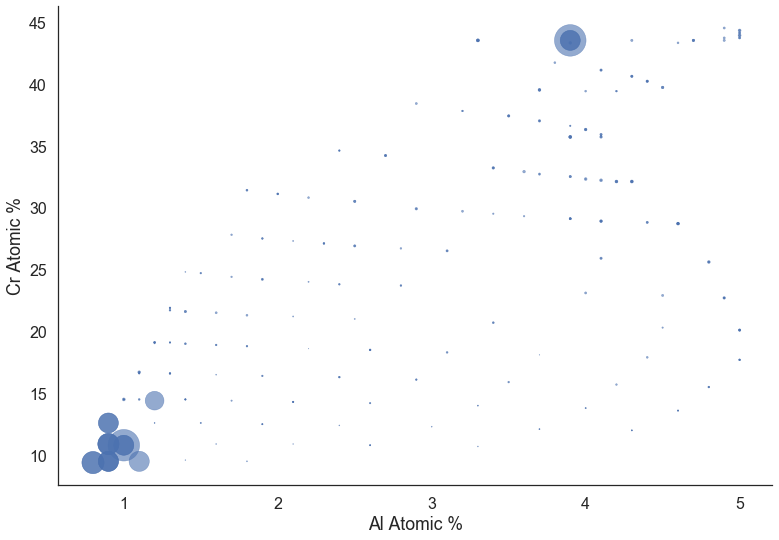

In [6]:
x = [r["data"]["Al"] for r in results]
y = [r["data"]["Cr"] for r in results]
s = [[r["aggregation_norm"]*1000 for r in results]]

fig, ax = plt.subplots()
plt.scatter(x, y, s=s, alpha=0.6)
ax.set_xlabel("Al Atomic %")
ax.set_ylabel("Cr Atomic %")
sns.despine()
plt.show()

## Joint Plots (Where we have observations)

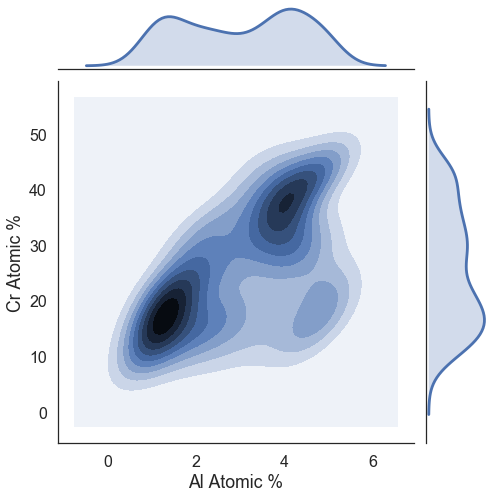

In [7]:
ax = sns.jointplot(np.asarray(x), np.asarray(y), kind="kde", 
                   shade=True, stat_func=None, size=7).set_axis_labels("Al Atomic %", "Cr Atomic %")

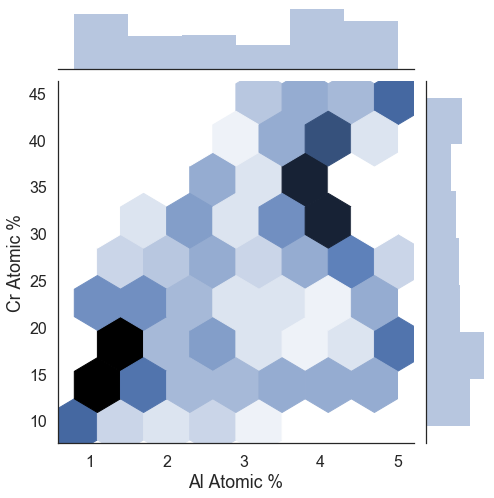

In [8]:
ax = sns.jointplot(np.asarray(x), np.asarray(y), kind="hex", 
                   gridsize=7, size=7, stat_func=None).set_axis_labels("Al Atomic %", "Cr Atomic %")